In [1]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import os

INPUT_PATH = "./data"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (48, 48)

print(EMOTIONS)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, image_size)
            img = img.astype('float32') / 255.0  # Normalize
            img = np.expand_dims(img, -1)
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [2]:
# Load the images 1
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
print(input_shape)

(48, 48, 1)


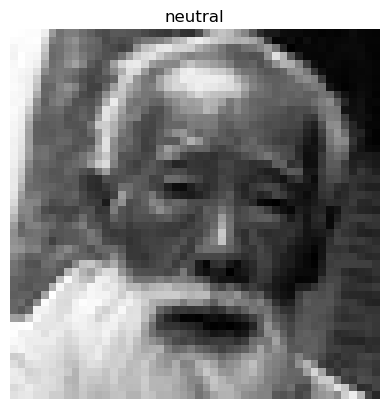

44402


In [3]:
import random
import matplotlib.pyplot as plt
# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx], cmap='gray')
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.axis('off')  # remove the grid
plt.show()
print(idx)

In [4]:
import pandas as pd

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + "/" + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
data_count = count_exp(INPUT_PATH, 'data')
print(data_count)

      anger  disgust  fear  happy  neutral   sad  surprise
data   8171     3024  8297  14031    11324  9168      8034


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

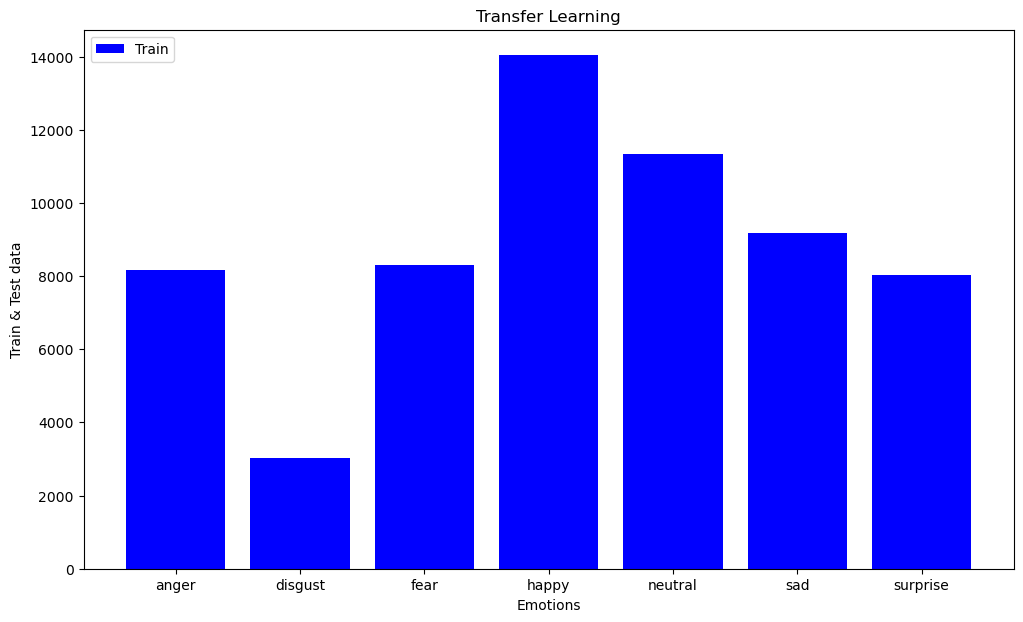

In [6]:
# # lot distribution of train/test dataste per class

x = list(data_count.columns)
y1 =data_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("Transfer Learning")
plt.savefig('distribution.png')
plt.show()


In [7]:
from tensorflow.keras.models import load_model
# Load the saved model
base_model = load_model("best_model.keras")
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)

# Assuming X_train and y_train are your training data and labels
train_dataset  = train_datagen.flow_from_directory(INPUT_PATH,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 62049 images belonging to 7 classes.


In [9]:
test_loss, test_accuracy = base_model.evaluate(X_test,y_test, verbose=1)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

388/388 [==============================] - 24s 61ms/step - loss: 1.2685 - accuracy: 0.6915
Test Loss: 1.2685256004333496
Test Accuracy: 0.691458523273468


388/388 [==============================] - 22s 57ms/step
Confusion Matrix
[[1139    7   48   54  241  138    7]
 [ 223   98   16   68  113   85    2]
 [ 132    2 1023   70  181  154   97]
 [  26    0    8 2582  134   51    5]
 [ 146    2   48  167 1576  320    6]
 [ 127    1   57   62  313 1270    4]
 [ 101    0  123  150  270   70  893]]
Classification Report
              precision    recall  f1-score   support

       anger       0.60      0.70      0.65      1634
     disgust       0.89      0.16      0.27       605
        fear       0.77      0.62      0.69      1659
       happy       0.82      0.92      0.87      2806
     neutral       0.56      0.70      0.62      2265
         sad       0.61      0.69      0.65      1834
    surprise       0.88      0.56      0.68      1607

    accuracy                           0.69     12410
   macro avg       0.73      0.62      0.63     12410
weighted avg       0.72      0.69      0.68     12410



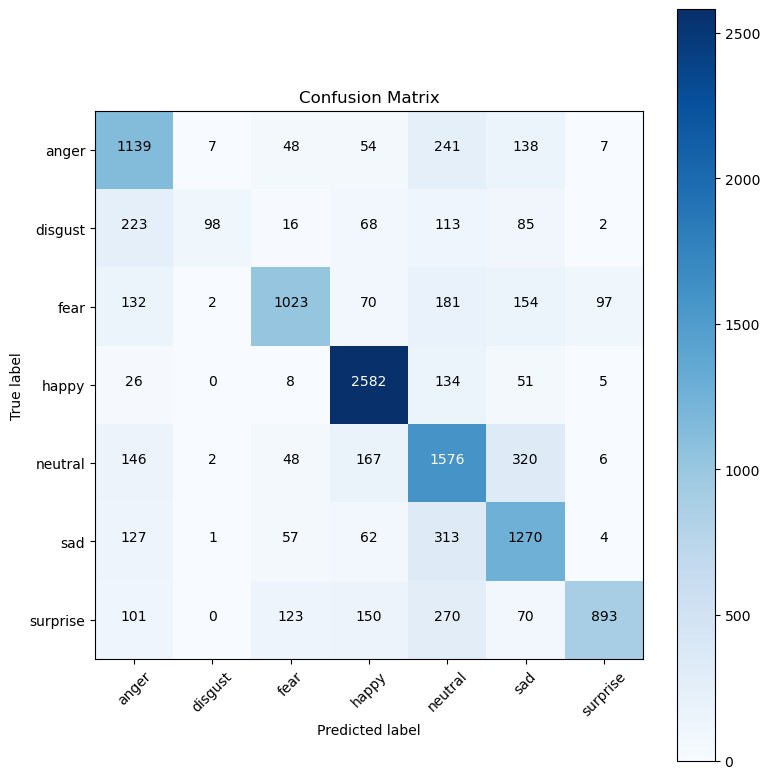

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_pred = base_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_test_indices = np.argmax(y_test, axis=1)


cm_test = confusion_matrix(y_test_indices, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test_indices, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [11]:
# Freezing Layers

for layer in base_model.layers[:16]:
    layer.trainable=False

In [12]:
# Model trainable

print("Model trainable",len(base_model.trainable_variables))

Model trainable 6


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.optimizers import Adam

# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization(name="tf_batch_normalization"))
model.add(GaussianNoise(0.01))

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001), name="tf_dense"))
model.add(BatchNormalization(name="tf_batch_normalization_1"))
model.add(Dropout(0.65, name="tf_dropout"))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),name="tf_dense_1"))
model.add(BatchNormalization(name="tf_batch_normalization_2"))
model.add(Dropout(0.65, name="tf_dropout_1"))

model.add(Dense(7, activation="softmax", name="tf_dense_2"))

model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 7)                 11112647  
                                                                 
 tf_batch_normalization (Bat  (None, 7)                28        
 chNormalization)                                                
                                                                 
 gaussian_noise (GaussianNoi  (None, 7)                0         
 se)                                                             
                                                                 
 tf_dense (Dense)            (None, 256)               2048      
                                                                 
 tf_batch_normalization_1 (B  (None, 256)              1024      
 atchNormalization)                                              
                                                        

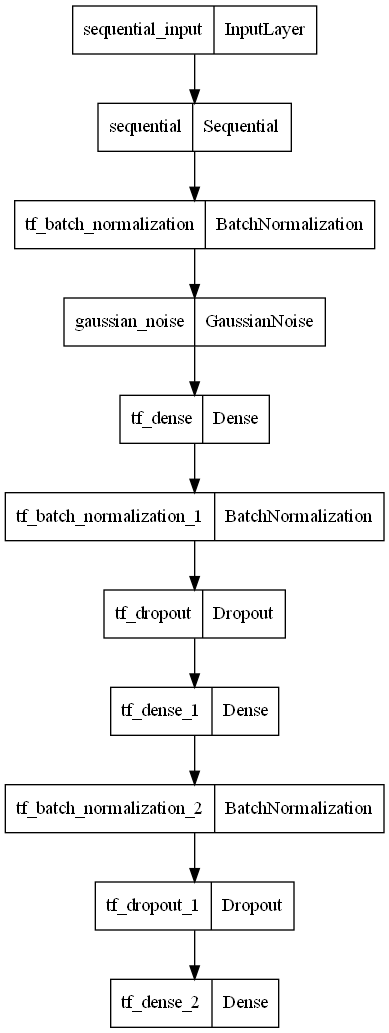

In [14]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_layer_names=True)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model_TL.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', overwrite=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr = 1e-10, mode='max')

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [16]:
epochs = 150


history = model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs = epochs,
                  callbacks = callbacks_list,
                  verbose =1)

Epoch 1/150
1551/1552 [============================>.] - ETA: 0s - loss: 2.1404 - accuracy: 0.4698
Epoch 1: val_accuracy improved from -inf to 0.70524, saving model to best_model_TL.keras
1552/1552 [==============================] - 157s 101ms/step - loss: 2.1403 - accuracy: 0.4698 - val_loss: 1.1186 - val_accuracy: 0.7052 - lr: 1.0000e-04
Epoch 2/150
1551/1552 [============================>.] - ETA: 0s - loss: 1.6537 - accuracy: 0.5647
Epoch 2: val_accuracy improved from 0.70524 to 0.71636, saving model to best_model_TL.keras
1552/1552 [==============================] - 158s 102ms/step - loss: 1.6537 - accuracy: 0.5647 - val_loss: 1.0353 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 3/150
1551/1552 [============================>.] - ETA: 0s - loss: 1.4332 - accuracy: 0.6062
Epoch 3: val_accuracy improved from 0.71636 to 0.72893, saving model to best_model_TL.keras
1552/1552 [==============================] - 155s 100ms/step - loss: 1.4332 - accuracy: 0.6062 - val_loss: 0.9999 - val_ac

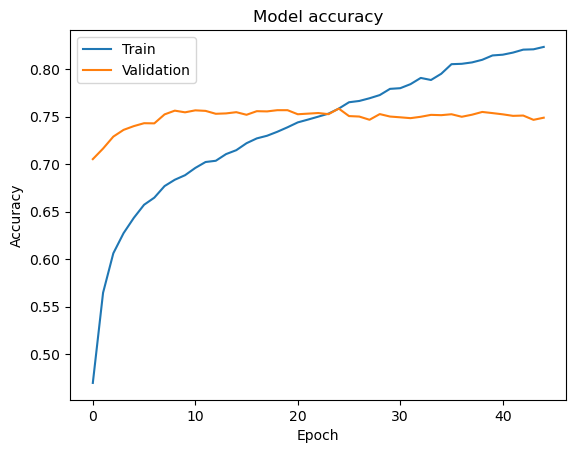

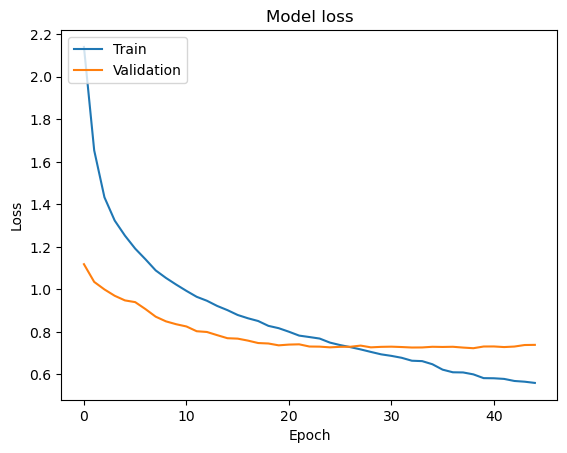

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
test_loss, test_accuracy = model.evaluate(X_test,y_test, verbose=1)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

388/388 [==============================] - 26s 66ms/step - loss: 0.7393 - accuracy: 0.7488
Test Loss: 0.7392597198486328
Test Accuracy: 0.748831570148468


In [19]:
from tensorflow.keras.models import load_model
# Load the saved model
best_model = load_model("best_model_TL.keras")
test_loss, test_accuracy = best_model.evaluate(X_test,y_test, verbose=1)
print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

388/388 [==============================] - 26s 67ms/step - loss: 0.7276 - accuracy: 0.7584
Test Loss: 0.727636456489563
Test Accuracy: 0.7584206461906433


388/388 [==============================] - 21s 54ms/step
Confusion Matrix
[[ 998  212   59   16   60  227   62]
 [  74  369   18   12   17   80   35]
 [  93   75  907   15   61  291  217]
 [   8   10    2 2602  137   21   26]
 [  27    9   20  124 1910  147   28]
 [  93  120   61   16  126 1363   55]
 [  30   59  169   53   72   80 1144]]
Classification Report
              precision    recall  f1-score   support

       anger       0.75      0.61      0.68      1634
     disgust       0.43      0.61      0.51       605
        fear       0.73      0.55      0.63      1659
       happy       0.92      0.93      0.92      2806
     neutral       0.80      0.84      0.82      2265
         sad       0.62      0.74      0.67      1834
    surprise       0.73      0.71      0.72      1607

    accuracy                           0.75     12410
   macro avg       0.71      0.71      0.71     12410
weighted avg       0.76      0.75      0.75     12410



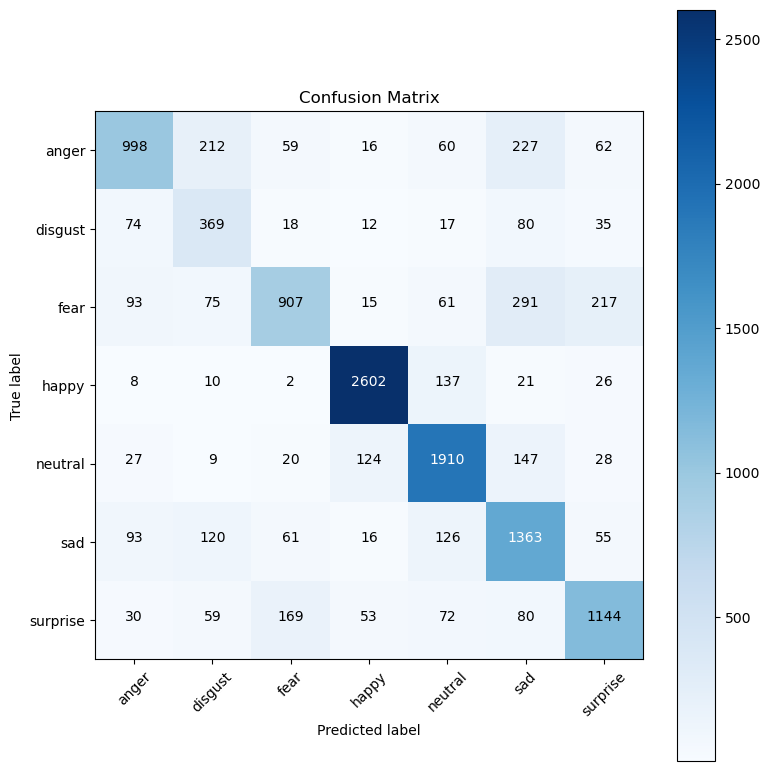

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_test_indices = np.argmax(y_test, axis=1)


cm_test = confusion_matrix(y_test_indices, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test_indices, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

388/388 [==============================] - 20s 52ms/step
Confusion Matrix
[[1166  110   65    5   47  150   91]
 [ 142  332   19    2    7   60   43]
 [ 159   27  776    5   39  357  296]
 [  88  127   28 1531   88  151  793]
 [ 232   28   31   29 1176  543  226]
 [ 224   35   59    6  154 1272   84]
 [  67   17  272    6   43   72 1130]]
Classification Report
              precision    recall  f1-score   support

       anger       0.56      0.71      0.63      1634
     disgust       0.49      0.55      0.52       605
        fear       0.62      0.47      0.53      1659
       happy       0.97      0.55      0.70      2806
     neutral       0.76      0.52      0.62      2265
         sad       0.49      0.69      0.57      1834
    surprise       0.42      0.70      0.53      1607

    accuracy                           0.59     12410
   macro avg       0.62      0.60      0.59     12410
weighted avg       0.66      0.59      0.60     12410



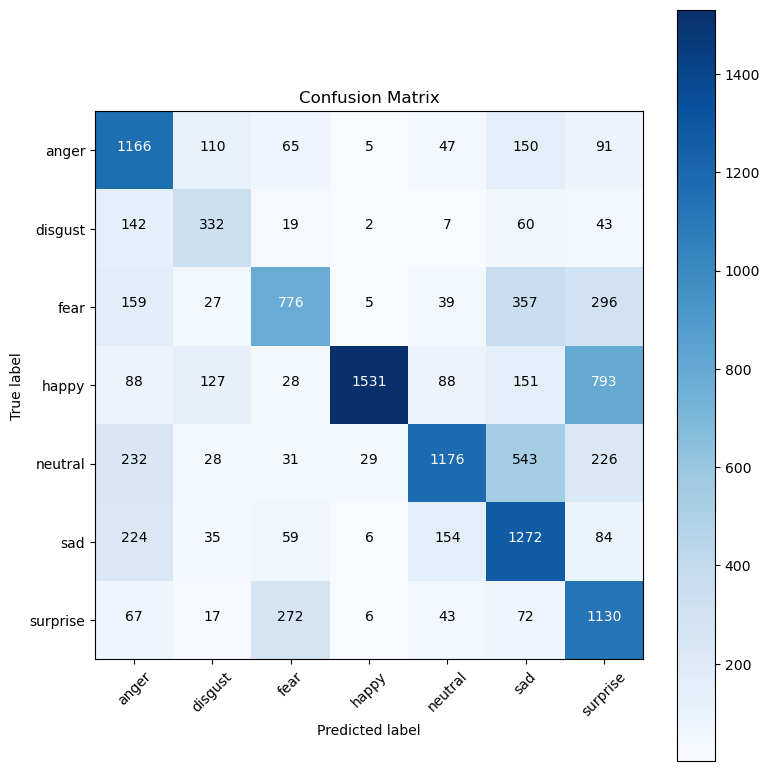

In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Load the saved model
best_model = load_model("transfer_learning.keras")
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_test_indices = np.argmax(y_test, axis=1)


cm_test = confusion_matrix(y_test_indices, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test_indices, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [22]:
model.save("model.keras")